# pix2pix for Maps to Aerial Image Translation

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import pixutils as pxu
from pix2pix import UNet, PatchGAN, fit
import wandb
import os

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
train_path = "pix2pix-maps/train/*.jpg"
val_path = "pix2pix-maps/val/*.jpg"

buffer_size = 256
image_size = 256

config = {
    "batch_size": 1,
    "lr_gen": 0.0002,
    "beta_1_gen": 0.5,
    "lr_disc": 0.0002,
    "beta_1_disc": 0.5,
    "l1_lambda": 100,
}

## Run the following code block on Kaggle only

In [4]:
train_path = f"/kaggle/input/{train_path}"
val_path = f"/kaggle/input/{val_path}"

## Load dataset

In [5]:
train = tf.data.Dataset.list_files(train_path)
val = tf.data.Dataset.list_files(val_path)

In [6]:
train = train.map(pxu.load_image)
train = train.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, image_size))
# data are in batches of size 'num_of_patches' after 'extract_patches'
train = train.unbatch()
train = train.map(lambda input_patches, real_patches: pxu.random_jitter(input_patches, real_patches, 286))
train = train.map(pxu.rescale_images)
train = train.shuffle(buffer_size)
train = train.batch(config["batch_size"])

val = val.map(pxu.load_image)
val = val.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, image_size))
# data are in batches of size 'num_of_patches' after 'extract_patches'
val = val.unbatch()
val = val.map(pxu.rescale_images)
val = val.batch(config["batch_size"])

## Visualize a few images

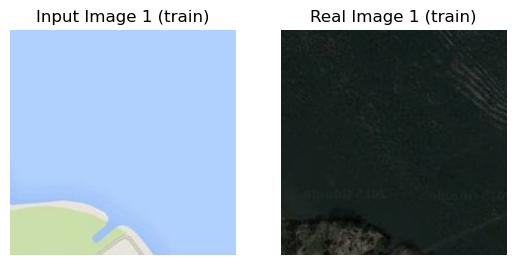

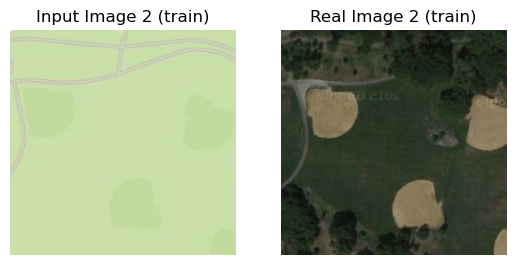

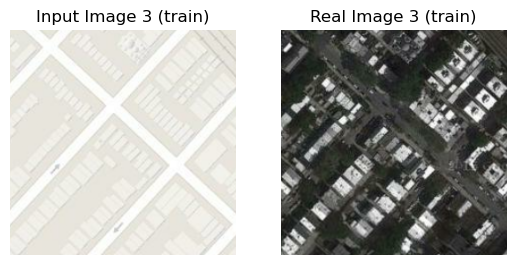

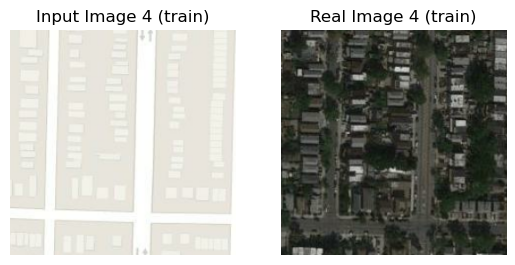

In [7]:
i = 0
for input_batch, real_batch in train.take(4):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "train"
        )

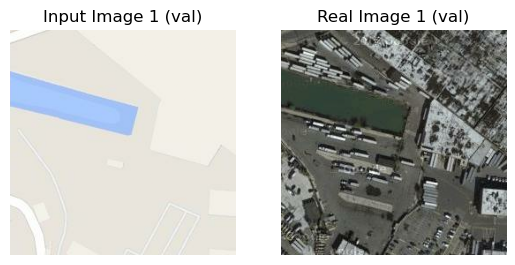

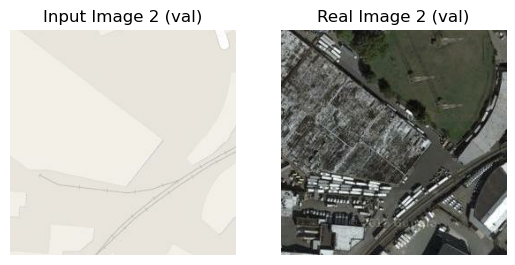

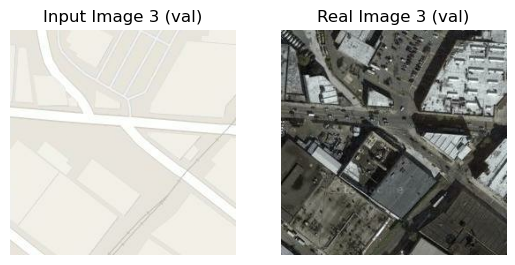

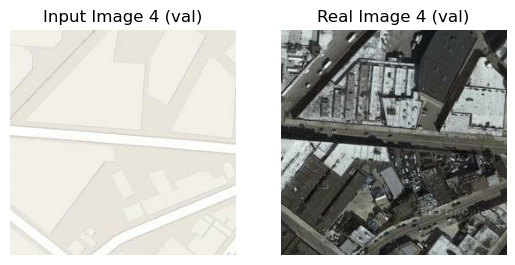

In [8]:
i = 0
for input_batch, real_batch in val.take(4):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "val"
        )

## Create models

In [9]:
G = UNet(input_shape=(image_size, image_size, 3))
D = PatchGAN(input_shape=(image_size, image_size, 3), patch_size=286)

config["epochs"] = 200 - 140

restore_last_epoch = 20
restore_run_id = "43powlxi"

if restore_last_epoch is not None:
    config["epochs"] -= restore_last_epoch
    run_path = f"nsiete23/pix2pix/{restore_run_id}"
    gen_file = wandb.restore(f"checkpoints/generator_{restore_last_epoch}.h5", run_path=run_path)
    disc_file = wandb.restore(f"checkpoints/discriminator_{restore_last_epoch}.h5", run_path=run_path)
    G = load_model(gen_file.name)
    D = load_model(disc_file.name)
    print(
        "Resumed:",
        gen_file.name,
        disc_file.name,
        sep=os.linesep
    )

g_optim = Adam(learning_rate=config["lr_gen"], beta_1=config["beta_1_gen"])
d_optim = Adam(learning_rate=config["lr_disc"], beta_1=config["beta_1_disc"])

Resumed:
/kaggle/working/checkpoints/generator_20.h5
/kaggle/working/checkpoints/discriminator_20.h5


## Train

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


2023-05-02 13:28:09.458141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch: 1, Step: 4384, Gen Loss: 41.8617, Disc Loss: 0.0011


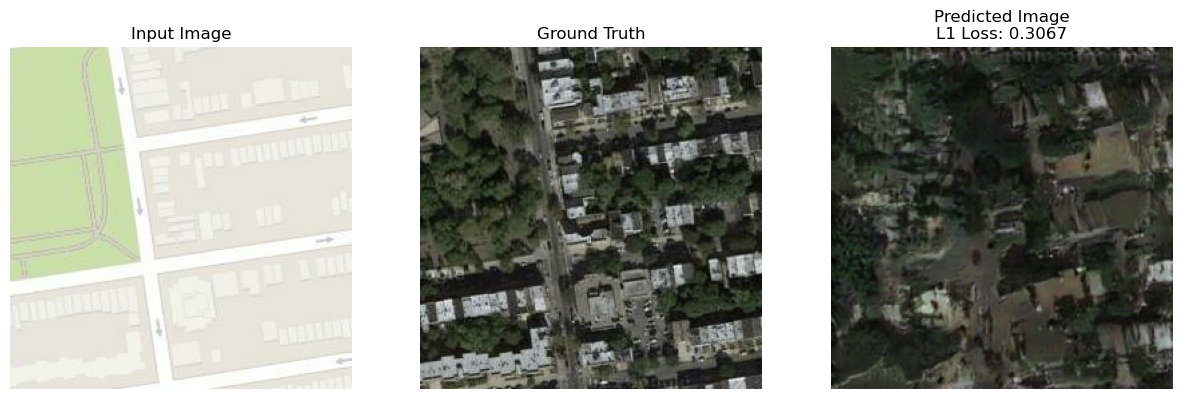

Epoch: 2, Step: 4384, Gen Loss: 36.8929, Disc Loss: 0.0045
Epoch: 3, Step: 4384, Gen Loss: 20.8344, Disc Loss: 0.2394
Epoch: 4, Step: 4384, Gen Loss: 33.8709, Disc Loss: 0.1353
Epoch: 5, Step: 4384, Gen Loss: 32.0435, Disc Loss: 0.0352
Epoch: 6, Step: 4384, Gen Loss: 30.1735, Disc Loss: 0.0285
Epoch: 7, Step: 4384, Gen Loss: 18.0374, Disc Loss: 0.0104
Epoch: 8, Step: 4384, Gen Loss: 13.6239, Disc Loss: 0.0502
Epoch: 9, Step: 4384, Gen Loss: 24.5117, Disc Loss: 0.0023
Epoch: 10, Step: 4384, Gen Loss: 30.2532, Disc Loss: 0.0180


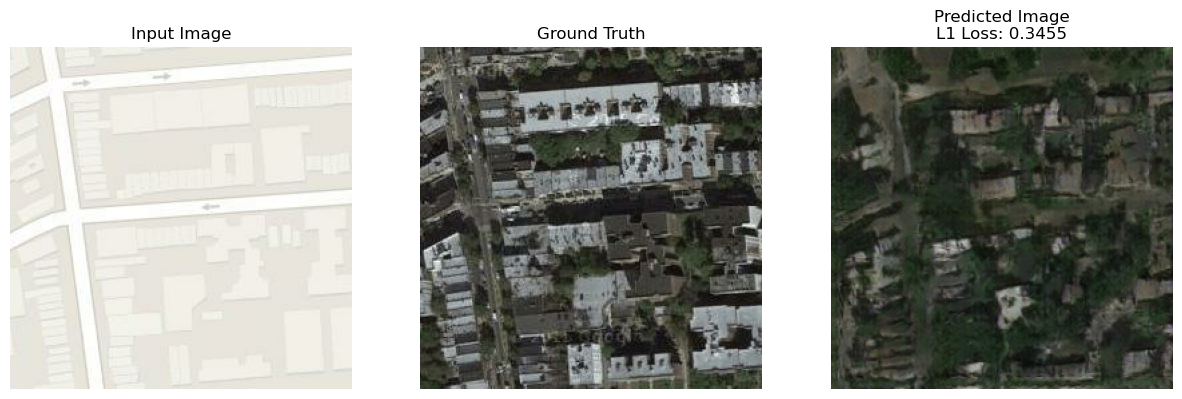

Epoch: 11, Step: 4384, Gen Loss: 6.9643, Disc Loss: 0.07644
Epoch: 12, Step: 4384, Gen Loss: 31.9482, Disc Loss: 0.0021
Epoch: 13, Step: 4384, Gen Loss: 34.1818, Disc Loss: 0.0250
Epoch: 14, Step: 4384, Gen Loss: 32.1391, Disc Loss: 0.0631
Epoch: 15, Step: 4384, Gen Loss: 20.0299, Disc Loss: 0.0042
Epoch: 16, Step: 4384, Gen Loss: 29.8372, Disc Loss: 0.0064
Epoch: 17, Step: 4384, Gen Loss: 44.4123, Disc Loss: 0.0120
Epoch: 18, Step: 4384, Gen Loss: 19.2457, Disc Loss: 0.0674
Epoch: 19, Step: 4384, Gen Loss: 16.5384, Disc Loss: 0.9416
Epoch: 20, Step: 4384, Gen Loss: 8.9926, Disc Loss: 0.07668


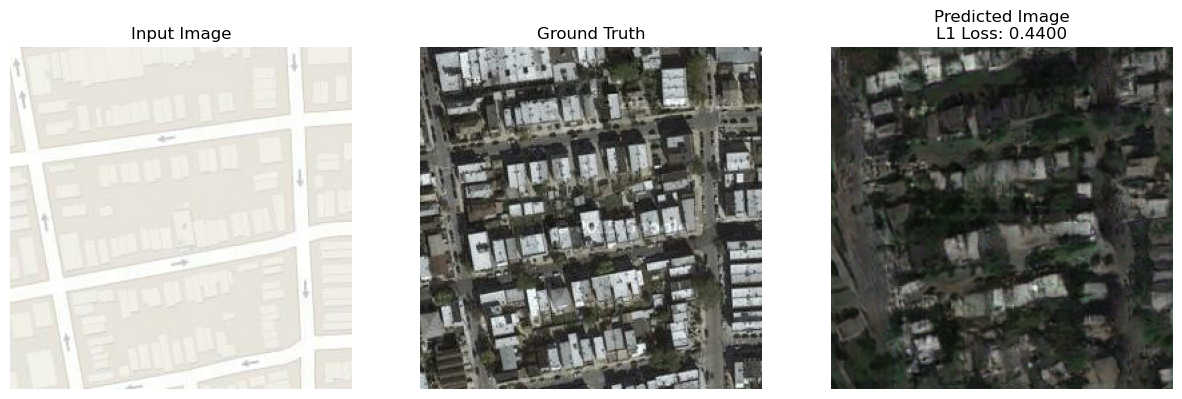

Epoch: 21, Step: 4384, Gen Loss: 26.9877, Disc Loss: 0.1580
Epoch: 22, Step: 4384, Gen Loss: 28.9867, Disc Loss: 0.0005
Epoch: 23, Step: 4384, Gen Loss: 15.2770, Disc Loss: 0.1758
Epoch: 24, Step: 4384, Gen Loss: 13.1913, Disc Loss: 0.1180
Epoch: 25, Step: 4384, Gen Loss: 25.6631, Disc Loss: 0.1500
Epoch: 26, Step: 4384, Gen Loss: 41.0272, Disc Loss: 0.0012
Epoch: 27, Step: 4384, Gen Loss: 38.9111, Disc Loss: 0.10805
Epoch: 28, Step: 4384, Gen Loss: 40.6395, Disc Loss: 1.1967
Epoch: 29, Step: 4384, Gen Loss: 18.9491, Disc Loss: 3.5373
Epoch: 30, Step: 4384, Gen Loss: 16.9363, Disc Loss: 1.1435


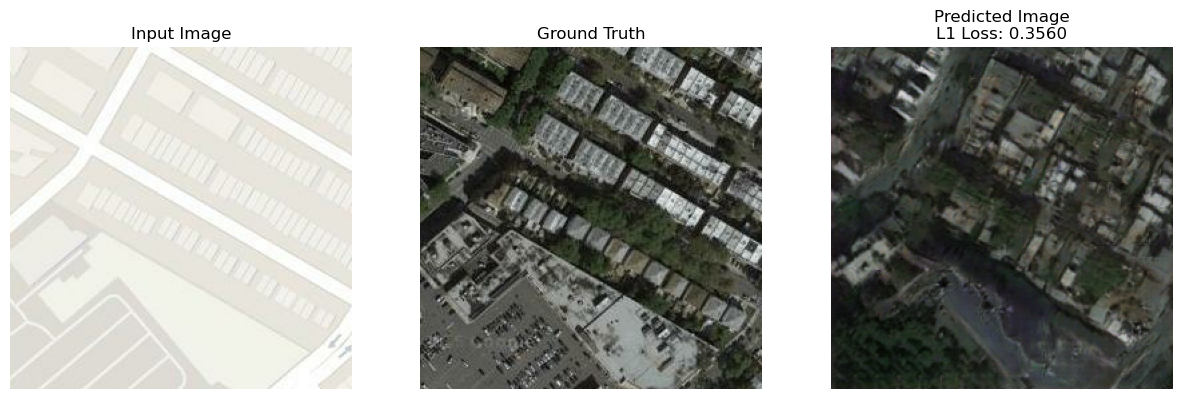

Epoch: 31, Step: 4384, Gen Loss: 22.7443, Disc Loss: 0.1624
Epoch: 32, Step: 4384, Gen Loss: 38.5907, Disc Loss: 0.0013
Epoch: 33, Step: 4384, Gen Loss: 19.1173, Disc Loss: 0.3083
Epoch: 34, Step: 4384, Gen Loss: 38.5407, Disc Loss: 0.2858
Epoch: 35, Step: 4384, Gen Loss: 34.3091, Disc Loss: 0.0053
Epoch: 36, Step: 4384, Gen Loss: 33.3369, Disc Loss: 0.0039
Epoch: 37, Step: 4384, Gen Loss: 26.6029, Disc Loss: 2.6583
Epoch: 38, Step: 4384, Gen Loss: 35.0454, Disc Loss: 0.0156
Epoch: 39, Step: 4384, Gen Loss: 41.7357, Disc Loss: 0.0010
Epoch: 40, Step: 4384, Gen Loss: 31.6309, Disc Loss: 0.0049


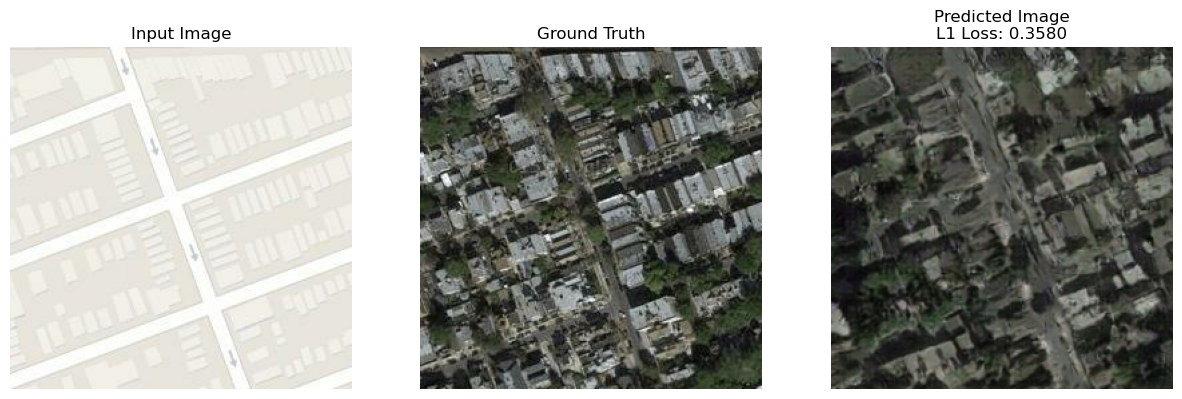

In [10]:
run = wandb.init(config=config, project="pix2pix")

fit(
    train_data=train,
    val_data=val,
    epochs=config["epochs"],
    generator=G,
    discriminator=D,
    generator_optimizer=g_optim,
    discriminator_optimizer=d_optim,
    l1_lambda=config["l1_lambda"],
)

In [11]:
wandb.finish()